In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nilmtk import DataSet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load UK-DALE dataset
ukdale = DataSet('ukdale.h5')
ukdale.set_window(start="2014-06-01", end="2014-07-01")
building = ukdale.buildings[1]
elec = building.elec

def load_data(generator):
    return next(generator)[('power', 'active')]

appliance_names = ['fridge freezer', 'washer dryer', 'dish washer', 'computer', 'television', 'kettle']
submeters = ukdale.buildings[1].elec.submeters()

# Check if submeters contain any data
if not submeters.meters:
    print("No submeters found for the selected building.")
else:
    appliance_data = {}
    for appliance_name in appliance_names:
        try:
            appliance_power = load_data(elec[appliance_name].load()).resample('1T').mean().fillna(0)
            appliance_data[appliance_name] = appliance_power
        except KeyError as e:
            print(f"Skipping {appliance_name}: {e}")

mains = ukdale.buildings[1].elec.mains()
mains_data = load_data(mains.load()).resample('1T').mean().fillna(0)

# Normalize the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X = scaler_X.fit_transform(mains_data.values.reshape(-1, 1))
y = np.column_stack([scaler_y.fit_transform(appliance_data[appliance_name].values.reshape(-1, 1)) for appliance_name in appliance_data.keys()])

# Sliding window approach
window_size = 60  # 1 hour windows for example
X_window = np.array([X[i:i + window_size] for i in range(len(X) - window_size)])
y_window = np.array([y[i:i + window_size] for i in range(len(y) - window_size)])

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_window, y_window, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)



In [105]:
# Define the CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100, return_sequences=True, activation='relu')))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(Dropout(0.3))
model.add(TimeDistributed(Dense(y_train.shape[2])))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)


In [106]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Train on 25884 samples, validate on 8628 samples
Epoch 1/20
25884/25884 [==============================] - 119s 5ms/sample - loss: 0.8288 - acc: 0.6255 - val_loss: 0.0082 - val_acc: 0.5374
Epoch 2/20
25884/25884 [==============================] - 120s 5ms/sample - loss: 0.0078 - acc: 0.5736 - val_loss: 0.0065 - val_acc: 0.6042
Epoch 3/20
25884/25884 [==============================] - 120s 5ms/sample - loss: 0.0070 - acc: 0.6207 - val_loss: 0.0059 - val_acc: 0.6556
Epoch 4/20
25884/25884 [==============================] - 128s 5ms/sample - loss: 0.0065 - acc: 0.6476 - val_loss: 0.0053 - val_acc: 0.7331
Epoch 5/20
25884/25884 [==============================] - 134s 5ms/sample - loss: 0.0058 - acc: 0.7039 - val_loss: 0.0049 - val_acc: 0.7832
Epoch 6/20
25884/25884 [==============================] - 129s 5ms/sample - loss: 0.0055 - acc: 0.7343 - val_loss: 0.0046 - val_acc: 0.8011
Epoch 7/20
25884/25884 [==============================] - 120s 5ms/sample - loss: 0.0052 - acc: 0.7548 - val_lo

In [108]:
model.save("cnnModel.h5")

In [109]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

8628/8628 [==============================] - 10s 1ms/sample - loss: 0.0038 - acc: 0.7805
Test Loss: 0.0037575006933160053, Test MAE: 0.7804821729660034


In [187]:
# Predict
y_pred = model.predict(X_test)
# Inverse transform predictions
# y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)
# Sum the values inside the arrays along axis 1 (sequence length) to get shape (8628, 6)
summed_predictions = np.sum(y_pred, axis=1)
y_test_sum = np.sum(y_test, axis=1)


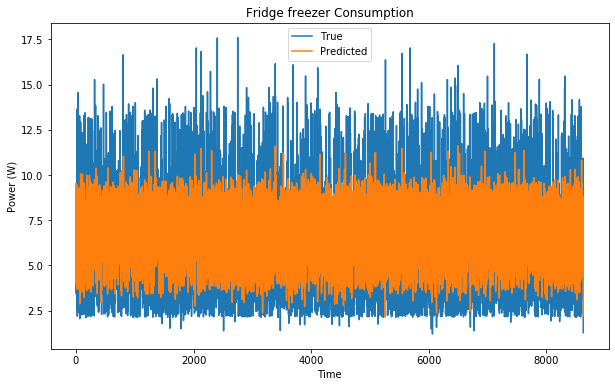

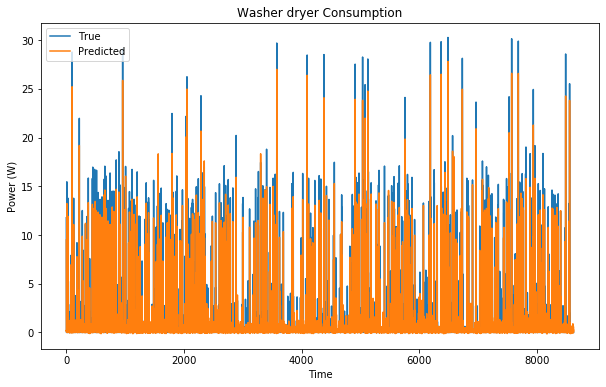

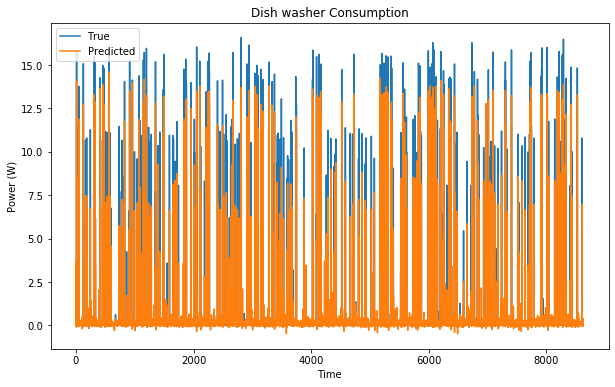

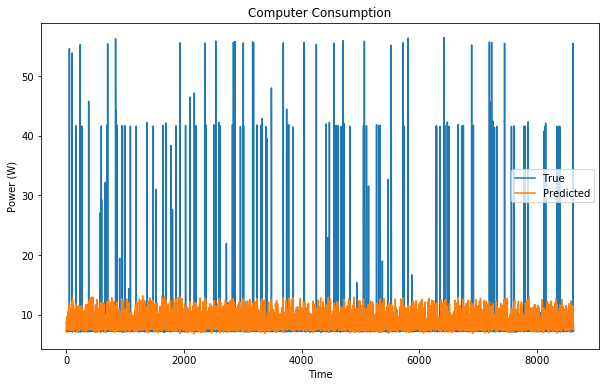

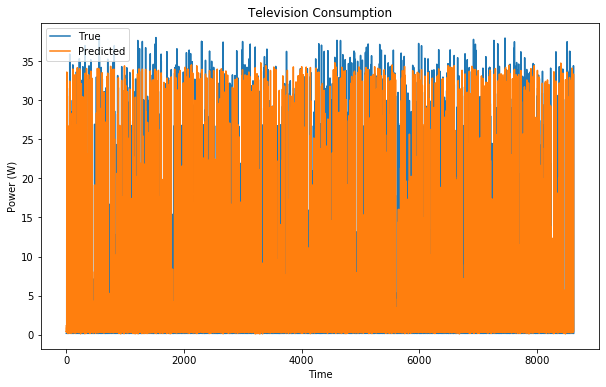

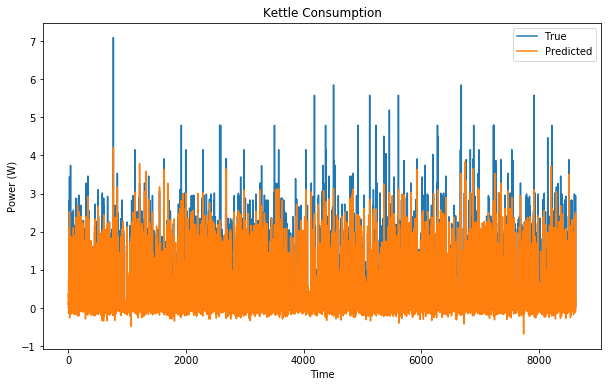

In [181]:
for i, appliance in enumerate(appliance_names):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_sum[:,i], label='True')
    plt.plot(summed_predictions[:,i], label='Predicted')
    plt.title(f'{appliance.capitalize()} Consumption')
    plt.xlabel('Time')
    plt.ylabel('Power (W)')
    plt.legend()
    plt.show()

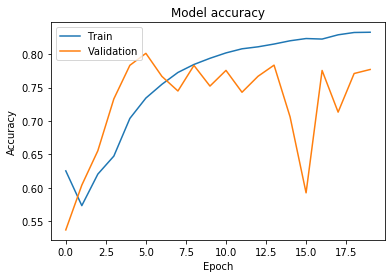

In [209]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()